In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [5]:
def run(filename, period_long, period_short, cash):

    data = pd.read_csv('quotes/' + filename, parse_dates=['<DATE>'])
    data.columns = [d[1:-1].lower() for d in data.columns]
    data['sma_long'] = data.close.rolling(window=period_long).mean()
    data['sma_short'] = data.close.rolling(window=period_short).mean()
    data['dev'] = data.sma_short - data.sma_long
    data['deal'] = np.nan

    ingame = False

    for i in range(period_long + 1, len(data) - 1):
        if ingame is False and data.dev[i-2] < 0 and data.dev[i-1] >= 0:
            data.loc[i, 'deal'] = 'in'
            ingame = True
        if ingame is True and data.dev[i-1] < 0:
            data.loc[i, 'deal'] = 'out'
            ingame = False

    deals = data[data.deal.notna()].copy()
    deals['profit'] = deals.open.rolling(window=2).apply(lambda x: (x[1] - x[0]) / x[0], raw=True)
    deals['total'] = deals.profit + 1
    deals = deals[deals['deal'] == 'out'].loc[:, ['date', 'profit', 'total']]
    deals.index = range(len(deals))
    deals.dropna(inplace=True)    
    
    win = len(deals[deals.profit > 0])
    loss = len(deals[deals.profit <= 0])
    percent_of_win = round(len(deals[deals.profit > 0]) * 100 / len(deals), 2)
    sharp = round(deals.profit.mean() / deals.profit.std(), 2)

    worse = round(min(deals.profit * cash), 2)
    best = round(max(deals.profit * cash), 2)
    total = round(sum(deals.profit * cash) + 10000, 2)

    res = cash
    drawdown = np.inf

    for p in deals.profit:
        res += res * p
        if drawdown > res:
            drawdown = res
    
    return filename.split('_')[0], period_long, period_short, win, loss, percent_of_win, sharp, \
           worse, best, total, round(drawdown, 2), round(res, 2)

In [25]:
files = os.listdir('quotes')
arr = []

for file in files:
    for i in range(2, 20):
        arr.append(run(file, 20, i, 10000))

In [26]:
data = pd.DataFrame(arr)
data.columns = ['quote', 'per_long', 'per_short', 'win', 'loss', '% of win', 'sharp', 
                'worse', 'best', 'total', 'drawdown', 'cumsum']

In [27]:
data.sort_values(by=['sharp'], ascending=False)

,quote,per_long,per_short,win,loss,% of win,sharp,worse,best,total,drawdown,cumsum
186,SBERP,20,8,18,11,62.07,0.44,-696.86,3262.42,22080.80,9365.38,29359.30
185,SBERP,20,7,16,12,57.14,0.42,-933.11,3060.70,21155.96,9540.61,26810.39
184,SBERP,20,6,17,13,56.67,0.41,-933.11,3409.90,21900.78,9540.67,28582.47
187,SBERP,20,9,18,11,62.07,0.41,-703.60,3560.85,21700.95,9154.41,27965.06
206,RSTI,20,10,12,18,40.00,0.40,-1091.62,5066.67,29348.03,8504.88,48199.42
129,AKRN,20,5,19,18,51.35,0.40,-599.20,1848.05,18314.74,9810.81,21589.27
128,AKRN,20,4,19,18,51.35,0.40,-446.55,1975.92,18171.95,9669.55,21321.48
203,RSTI,20,7,12,17,41.38,0.39,-810.42,4335.55,28176.75,9234.20,43329.58
205,RSTI,20,9,13,17,43.33,0.39,-937.68,5546.00,29812.74,8227.99,48958.35
204,RSTI,20,8,12,19,38.71,0.39,-740.68,4533.76,29752.86,9163.13,49530.62


In [28]:
data.to_csv('SMA_vs_SMA_result.csv')

In [29]:
data = pd.read_csv('SMA_vs_SMA_result.csv')
data['sharp_total'] = data.sharp * data.total

In [30]:
data.quote.unique()

array(['TATNP', 'TGKA', 'UPRO', 'CHMF', 'SBER', 'PLZL', 'VTBR', 'AKRN',
       'SNGSP', 'SNGS', 'SBERP', 'RSTI', 'TATN', 'ALRS'], dtype=object)

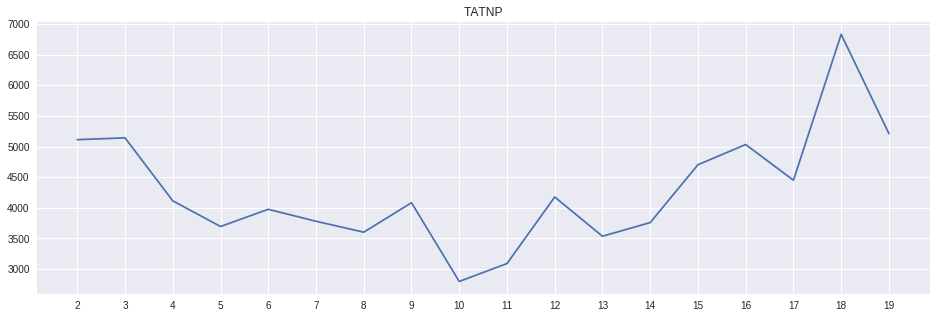

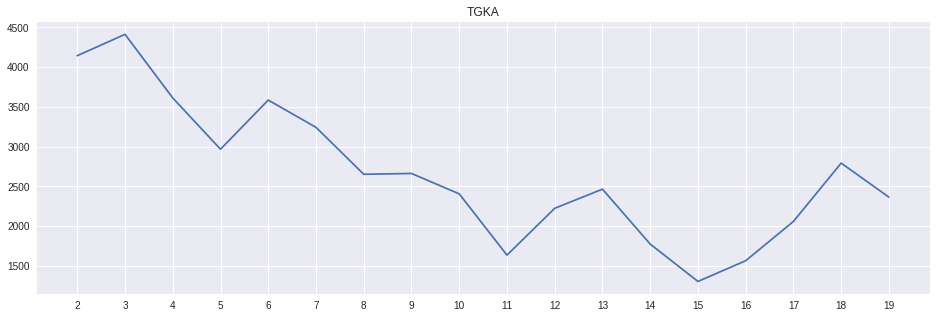

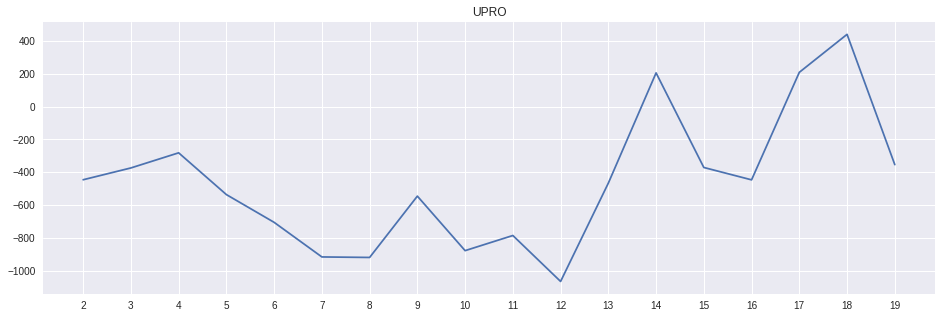

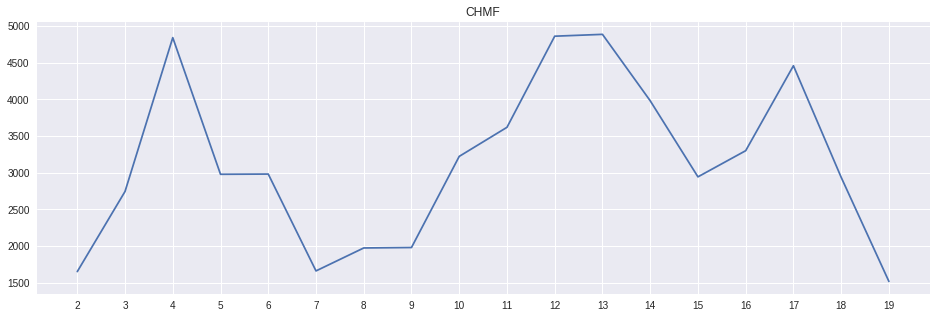

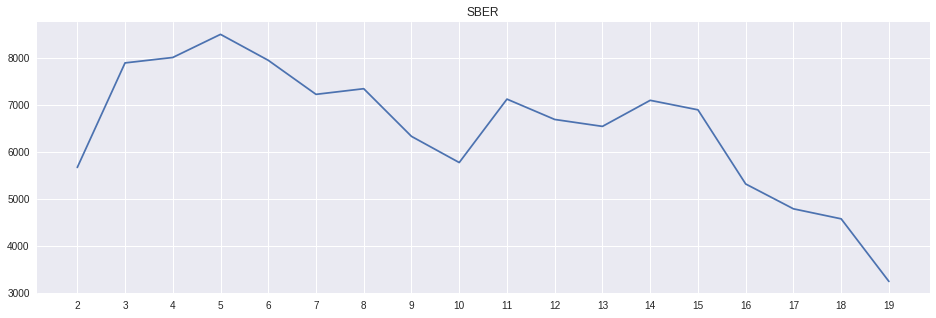

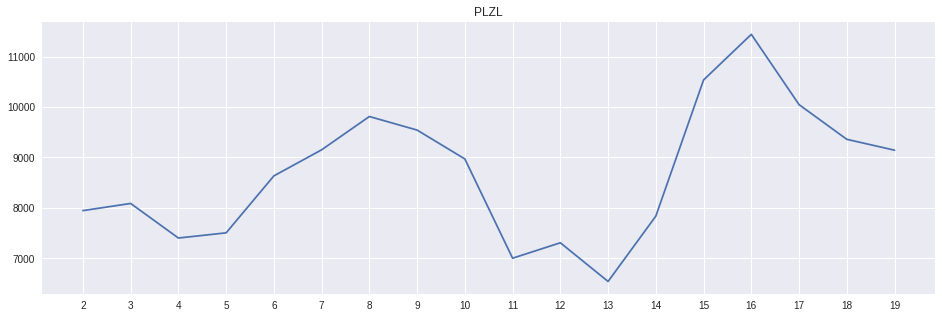

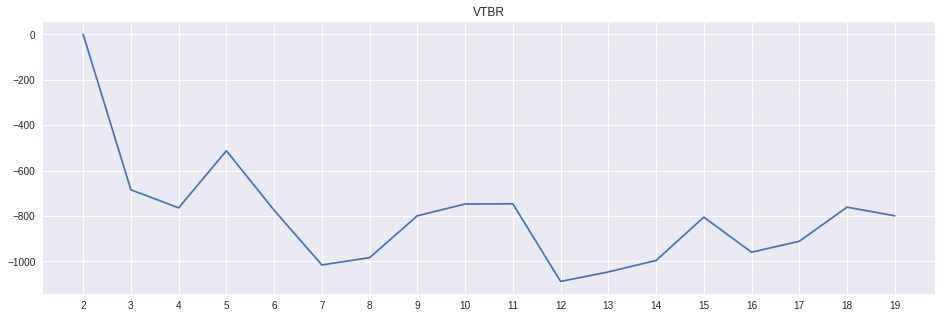

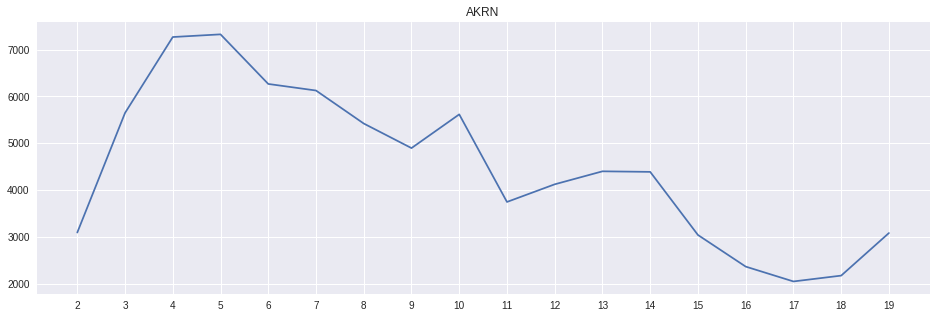

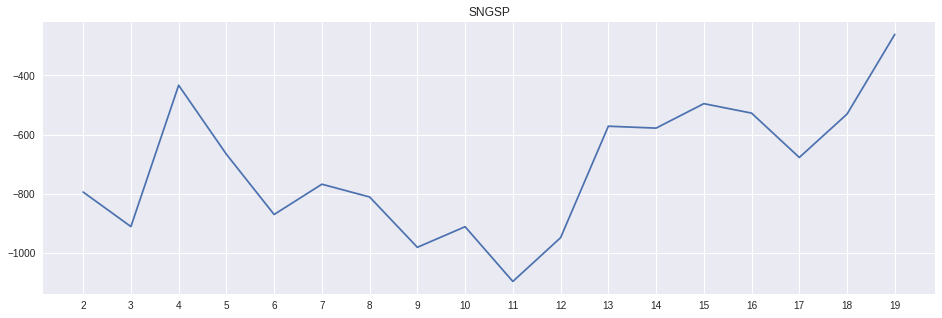

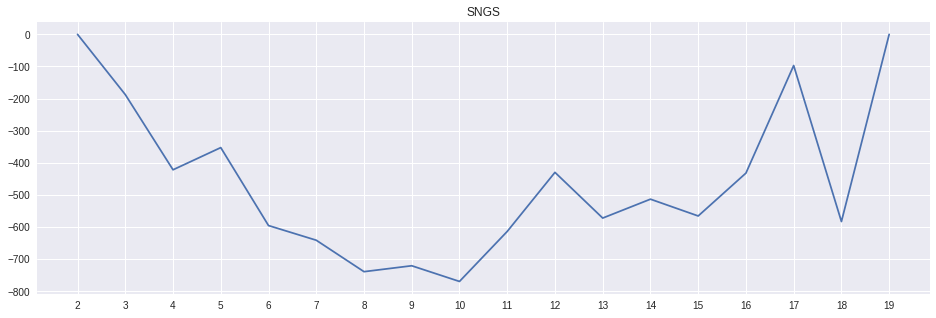

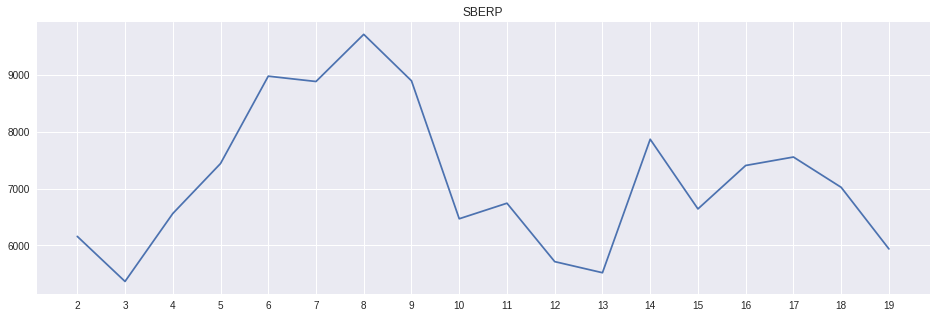

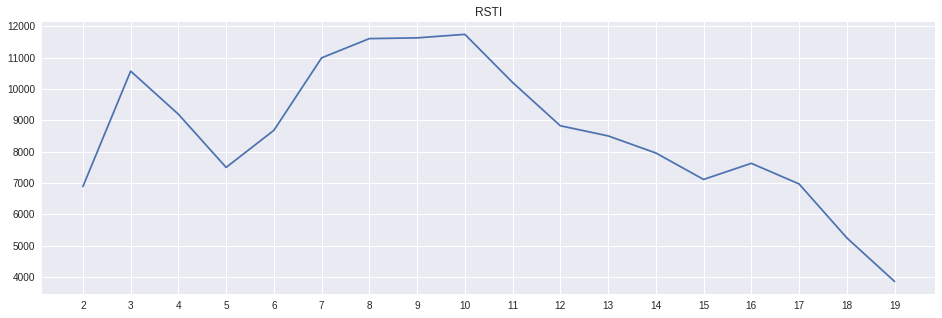

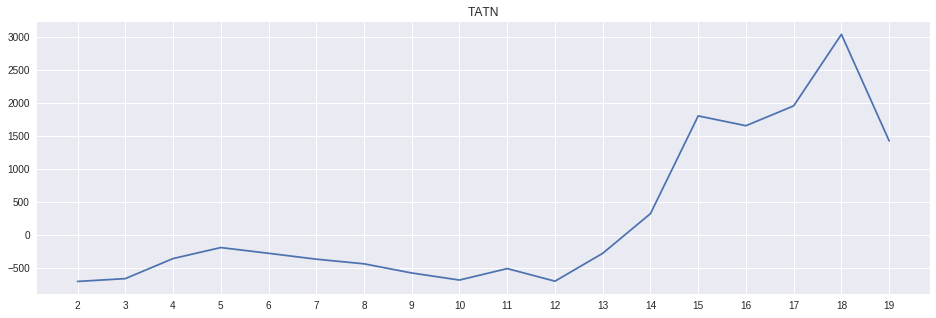

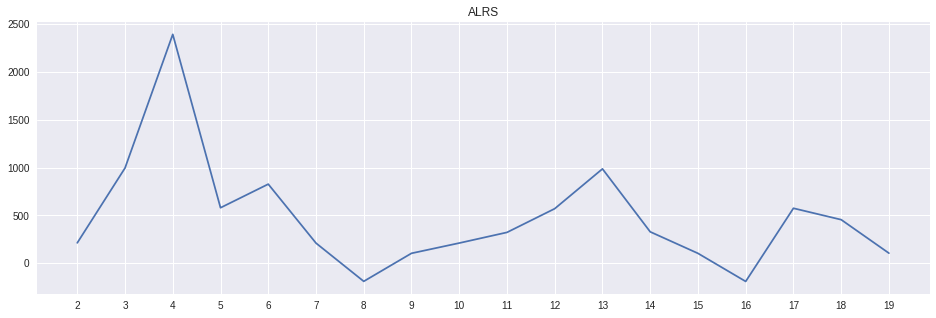

In [32]:
for quote in data.quote.unique():
    x = data[data.quote == quote].per_short
    y = data[data.quote == quote].sharp_total
    plt.figure(figsize=(16, 5))
    plt.plot(x, y)
    plt.title(quote)
    plt.xticks(np.arange(2, 20, 1))

In [35]:
data[data.per_short == 5].sort_values(by=['sharp_total'], ascending=False)

,Unnamed: 0,quote,per_long,per_short,win,loss,% of win,sharp,worse,best,total,drawdown,cumsum,sharp_total
75,75,SBER,20,5,22,18,55.00,0.38,-944.78,2919.87,22366.03,9900.38,30141.20,8499.0914
93,93,PLZL,20,5,16,26,38.10,0.28,-994.94,5033.75,26809.03,9477.61,37300.44,7506.5284
201,201,RSTI,20,5,12,21,36.36,0.30,-938.66,3929.24,24977.96,8966.00,31882.77,7493.3880
183,183,SBERP,20,5,18,16,52.94,0.35,-802.55,3535.69,21259.77,9228.25,26718.16,7440.9195
129,129,AKRN,20,5,19,18,51.35,0.40,-599.20,1848.05,18314.74,9810.81,21589.27,7325.8960
3,3,TATNP,20,5,15,24,38.46,0.22,-897.78,2837.45,16793.68,8841.33,17573.72,3694.6096
57,57,CHMF,20,5,15,22,40.54,0.20,-583.48,2240.02,14892.97,9677.38,15103.91,2978.5940
21,21,TGKA,20,5,14,30,31.82,0.15,-1095.35,8522.05,19786.95,8552.74,18586.54,2968.0425
237,237,ALRS,20,5,13,27,32.50,0.05,-798.30,2710.00,11591.75,7734.13,10668.42,579.5875
219,219,TATN,20,5,17,35,32.69,-0.02,-1015.42,2159.90,9314.14,6854.03,8537.43,-186.2828
